In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from adjustText import adjust_text
import numpy as np
from scipy.stats import chi2_contingency
from collections import Counter, defaultdict
import scipy
import scipy
from sklearn.manifold import TSNE, MDS
from umap import UMAP
import requests

In [2]:
def query_glkb(cypher):
    url = "https://glkb.dcmb.med.umich.edu/api/others/_cypher_query"
    return requests.get(url, params = {'cypher': cypher}, verify=False)

In [10]:
cypher = """MATCH (a:Article) RETURN COUNT(a)"""
total_articles = query_glkb(cypher).json()[0][0]
n_targets = dict(zip(all_genes['g.id'], all_genes['g.n_citation']))

/home/hyhao/miniconda3/envs/KG/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'glkb.dcmb.med.umich.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


# load data

## T2D effector genes in T2DKP

In [3]:
cypher = """match (g:Gene) where g.n_citation>50 return g.id, g.name, g.n_citation limit 1"""
res = query_glkb(cypher)

/home/hyhao/miniconda3/envs/KG/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'glkb.dcmb.med.umich.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [4]:
effector = pd.read_csv('data/t2d_effector_summary_251undefined_filtered.csv')
cypher = """match (g:Gene) where g.n_citation>50 return g.id, g.name, g.n_citation"""

result = query_glkb(cypher)
result = pd.DataFrame(result.json(), columns=['g.id', 'g.name', 'g.n_citation'])
all_genes = result.iloc[:-2]

effector = effector.merge(all_genes, right_on='g.name', left_on='Gene', how='left').dropna(subset=['g.id'])

/home/hyhao/miniconda3/envs/KG/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'glkb.dcmb.med.umich.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


## RFX6-related DEG data

In [5]:
fc2 = pd.read_csv('data/41586_2023_6693_MOESM5_ESM.csv')
fc2.columns = ['Symbol', 'log2FoldChange (FC)', 'abs(FC)', 'P-adjusted']
fc2 = fc2.drop_duplicates(subset=['Symbol'])

# filter
steve = fc2

## T2D-related DEG data

In [6]:
fc = pd.read_csv('data/diffExpr_combine_FDR0.05_WT_RNAseq_all.csv')
exp = pd.read_csv('data/TPM_files_of_T2D_KO_project.txt', sep='\t')

chen = pd.DataFrame({
    'symbol': exp['symbol'],
    'expression': exp[['ABCC8_C1', 'ABCC8_C2', 'ABCC8_C3', 'APOE_C1',
    'APOE_C2', 'APOE_C3', 'CDC123_C1', 'CDC123_C2', 'CDC123_C3',
    'CDKAL1_C1', 'CDKAL1_C2', 'CDKAL1_C3', 'COBLL1_C1', 'COBLL1_C2',
    'COBLL1_C3', 'GCKR_C1', 'GCKR_C2', 'GCKR_C3', 'GIPR_C2', 'GIPR_C3',
    'GIPR_C4', 'HNF1A_C3', 'HNF1A_C4', 'HNF1A_S32', 'HNF4A_C1', 'HNF4A_C2',
    'HNF4A_C3', 'HTT_C1', 'HTT_C2', 'HTT_C3', 'IGF2BP2_C1', 'IGF2BP2_C2',
    'IGF2BP2_C3', 'KCNJ11_C1', 'KCNJ11_C2', 'KCNJ11_C3', 'WT1_C1', 'WT1_C2',
    'WT1_C3', 'SLC30A8_C2', 'SLC30A8_C3', 'SLC16A11_C1', 'SLC16A11_C2',
    'SLC16A11_C3', 'SLC30A8_C1', 'TCF7L2_C1', 'TCF7L2_C2', 'TCF7L2_C3',
    'TGFB1_C1', 'TGFB1_C2', 'TGFB1_C3', 'TLE4_C1', 'TLE4_C2', 'TLE4_C3',
    'TMCC_C1', 'TMCC_C2', 'TMCC_C4', 'WT2_C1', 'WT2_C2', 'WT2_C3',
    'WDR13_C1', 'WDR13_C2', 'WDR13_C3', 'WFS1_C1', 'WFS1_C2', 'WFS1_C3',
    'WFS1_C4']].mean(axis=1).rank(pct=True),
    'DEG': exp[['symbol']].merge(fc[['symbol', 'NumberOfSamples']].drop_duplicates(subset=['symbol']), on='symbol', how='left')['NumberOfSamples']
    })
chen['DEG'].fillna(0, inplace=True)
chen = chen.sort_values('expression', ascending=False).drop_duplicates(subset='symbol')

# filter
chen = chen[((chen['expression']>=0.8) & (chen['DEG']>3)) | ((chen['expression']>=0.8) & (chen['symbol'].isin(effector['Gene'])))]

## merged gene set

In [7]:
merged_gene_set = pd.unique(chen['symbol'].to_list() + steve['Symbol'].to_list() + effector['Gene'].to_list() + ['RFX6'])
merged_gene_set = all_genes[all_genes['g.name'].isin(merged_gene_set)]
merged_gene_set['source'] = None
merged_gene_set.loc[merged_gene_set['g.name'].isin(chen['symbol']), 'source'] = 'chen'
merged_gene_set.loc[merged_gene_set['g.name'].isin(steve['Symbol']), 'source'] = 'steve'
merged_gene_set.loc[merged_gene_set['g.name'].isin(effector['Gene']), 'source'] = 'effector'
merged_gene_set.loc[merged_gene_set['g.name']=='RFX6', 'source'] = 'steve'

/tmp/ipykernel_76941/1671391068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_gene_set['source'] = None


# RF6-related genes

In [8]:
def coocc2(id1, id2):
    cypher = """MATCH (v1:Vocabulary)<-[:ContainTerm]-(a:Article)-[:ContainTerm]->(v2:Vocabulary) WHERE v1.id='{}' AND v2.id='{}' RETURN COUNT(DISTINCT a)"""

    corr = dict()
    for i, g in enumerate(id1):
        n_arts = dict()
        for j, g2 in enumerate(id2):
            res = query_glkb(cypher.format(g, g2)).json()
            if len(res) > 0:
                n_arts[g2] = res[0][0]
            else:
                n_arts[g2] = 0
        corr[g] = n_arts
    return corr

def calc_sig(corr_df):
    corr_df['exp_occ'] = corr_df.apply(lambda x: n_targets[x['g1']] * n_targets[x['g2']] / total_articles, axis=1)
    corr_df['pval'] = None
    corr_df['pmi'] = None

    for i, r in corr_df.iterrows():
        corr_df.loc[i, 'pval'] = chi2_contingency([[r['obs_occ'], n_targets[r['g1']] - r['obs_occ']],
                                                [n_targets[r['g2']] - r['obs_occ'], total_articles - r['obs_occ']]])[1]
        corr_df.loc[i, 'pmi'] = np.log((r['obs_occ'] + 1) / (r['exp_occ'] + 1)) 
    return corr_df

In [ ]:
thres = 0

sub = merged_gene_set[merged_gene_set['g.name'].isin(steve['Symbol'])]
corr = coocc2(['hgnc:21478'], sub['g.id'].to_list())
corr_df = pd.DataFrame(corr).reset_index().melt(id_vars=['index'])
corr_df.columns = ['g1', 'g2', 'obs_occ']
corr_df = calc_sig(corr_df)

rfx6_related = corr_df[(corr_df['pval']<=thres) & (corr_df['pmi']>0)]
rfx6_related['symbol1'] = rfx6_related['g1'].apply(dict(zip(merged_gene_set['g.id'], merged_gene_set['g.name'])).get)
rfx6_related['symbol2'] = rfx6_related['g2'].apply(dict(zip(merged_gene_set['g.id'], merged_gene_set['g.name'])).get)

# T2D-related genes

In [ ]:
sub = merged_gene_set[merged_gene_set['g.name'].isin(chen['symbol']) | merged_gene_set['g.name'].isin(effector['Gene'])]
corr = coocc2(list(set(rfx6_related['g1'].to_list() + rfx6_related['g2'].to_list())), sub['g.id'].to_list())
corr_df = pd.DataFrame(corr).reset_index().melt(id_vars=['index'])
corr_df.columns = ['g1', 'g2', 'obs_occ']
corr_df = calc_sig(corr_df)

T2D_related = corr_df[(corr_df['pmi']>0)].sort_values('pval').iloc[:145]

In [ ]:
all_related = pd.concat([rfx6_related, T2D_related]).drop_duplicates()
all_related['symbol1'] = all_related['g1'].apply(dict(zip(merged_gene_set['g.id'], merged_gene_set['g.name'])).get)
all_related['symbol2'] = all_related['g2'].apply(dict(zip(merged_gene_set['g.id'], merged_gene_set['g.name'])).get)
all_related['comb'] = all_related.apply(lambda x: '|'.join(set([x['g1'], x['g2']])), axis=1)
all_related = all_related.drop_duplicates(subset='comb')
all_related = all_related[all_related['g1']!=all_related['g2']]

# visualization

In [53]:
def coocc3(id1, id2):
    cypher = """MATCH (v:Vocabulary) WHERE v.id IN ['mondo:0005015', 'mesh:D003924', 'mesh:D003922', 'doid:0050524']
WITH v AS t2d
MATCH (v1:Vocabulary)<-[:ContainTerm]-(a:Article)-[:ContainTerm]->(v2:Vocabulary) WHERE v1.id='{}' AND v2.id='{}' 
RETURN COUNT(DISTINCT a), COUNT(DISTINCT CASE WHEN (a)-[:ContainTerm]->(t2d) THEN a END)"""

    corr = dict()
    t2d_corr = dict()
    for g in id1:
        n_arts = []
        for g2 in id2:
            n_arts.append(query_glkb(cypher.format(g, g2)).json())
        corr[g] = [i[0][0] for i in n_arts]
        t2d_corr[g] = [i[0][1] for i in n_arts]
    return pd.DataFrame(corr, index=id2), pd.DataFrame(t2d_corr, index=id2)


def calc_sig2(corr_df):
    co_occurrence_matrix = corr_df.to_numpy()
    expected_matrix = np.array([[n_targets[i] * n_targets[j] / total_articles for i in corr_df.columns] for j in corr_df.index])

    p_value_matrix = np.zeros(co_occurrence_matrix.shape)
    for i in range(co_occurrence_matrix.shape[0]):
        for j in range(co_occurrence_matrix.shape[1]):
            observed = co_occurrence_matrix[i, j]+1e-5
            p_value_matrix[i, j] = chi2_contingency([[observed, max(0, n_targets[corr_df.index[i]] - observed)],
                                            [max(0, n_targets[corr_df.columns[j]] - observed), total_articles - observed]])[1]
    p_values = pd.DataFrame(p_value_matrix, index=corr_df.index, columns=corr_df.columns)
    pmi_matrix = np.log((co_occurrence_matrix + 1) / (expected_matrix + 1)) 
    return p_values, pmi_matrix

In [ ]:
c = all_related['symbol1'].value_counts()
g_subset = list(set(list(c[c>0].index) + rfx6_related['symbol2'].to_list() + effector['Gene'].to_list()))
gs = [dict(zip(all_genes['g.name'], all_genes['g.id'])).get(i) for i in g_subset]

corr_df, t2d_corr_df = coocc3(gs, gs)
p_value_matrix, pmi_matrix = calc_sig2(corr_df)
t2d_prop = (t2d_corr_df / corr_df).fillna(0)

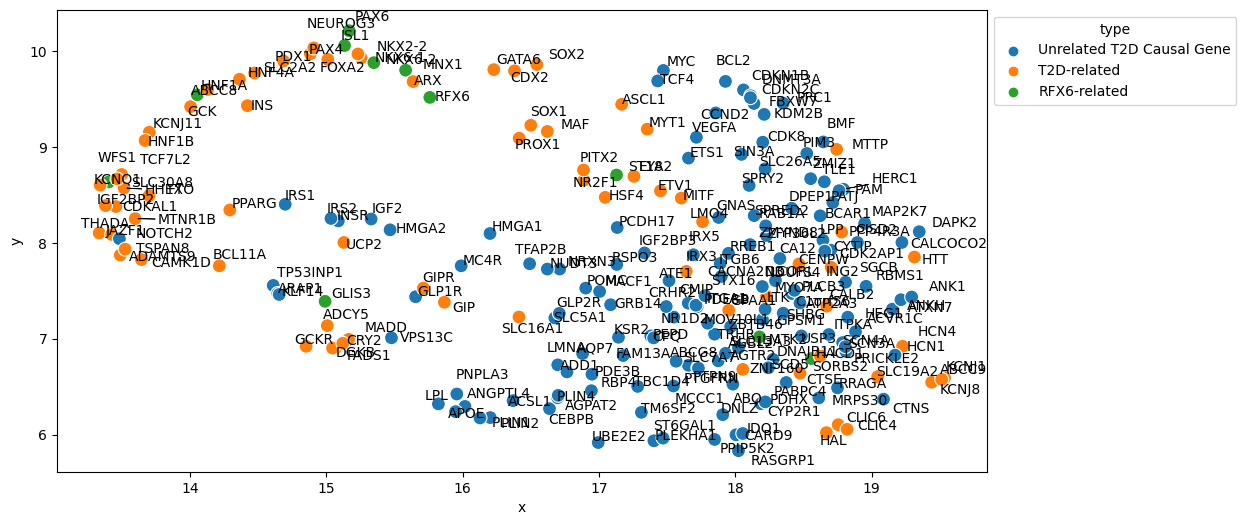

In [57]:
emb = UMAP().fit_transform(pmi_matrix)
emb_df = pd.DataFrame({'x': emb[:,0], 'y': emb[:,1], 'name': [dict(zip(all_genes['g.id'], all_genes['g.name'])).get(i) for i in corr_df.index], 'id': corr_df.index})
emb_df['n_citation'] = emb_df['id'].apply(dict(zip(merged_gene_set['g.id'], merged_gene_set['g.n_citation'])).get)
emb_df['type'] = 'Unrelated T2D Causal Gene'
sub = all_related[~all_related['comb'].isin(rfx6_related.apply(lambda x: '|'.join(set([x['g1'], x['g2']])), axis=1))]
emb_df.loc[emb_df['id'].isin(sub['g1']), 'type'] = 'T2D-related'
emb_df.loc[emb_df['id'].isin(rfx6_related['g1']), 'type'] = 'RFX6-related'
emb_df.loc[emb_df['id']=='hgnc:21478', 'type'] = 'RFX6-related'
emb_df['display'] = None
emb_df.loc[emb_df['type']=='RFX6-related', 'display'] = emb_df.loc[emb_df['type']=='RFX6-related', 'name']

props = t2d_prop['hgnc:21478'].reset_index()
props.columns = ['id', 't2d_prop']
emb_df = emb_df.merge(props, on='id', how='left')

emb_df['rfx6_corr'] = emb_df['id'].apply(lambda x: corr_df.loc['hgnc:21478', x])

emb_df['group'] = 'Others'
emb_df.loc[emb_df['name'].isin(['RFX6']), 'group'] = 'RFX6'
emb_df.loc[emb_df['name'].isin(['KCNJ11','GCK','INS','ABCC8','HNF1B','HNF4A','HNF1A', 'WFS1', 'SLC30A8', 'GLIS3', 'MTNR1B']), 'group'] = 'insulin secretion'
emb_df.loc[emb_df['name'].isin(['PAX6', 'ISL1', 'NKX6-2', 'ARX', 'NKX6-1', 'NKX2-2', 'NEUROG3', 'PAX4', 'PDX1', 'MNX1']), 'group'] = 'beta cell development'
emb_df.loc[emb_df['name'].isin(['GLP1R', 'GIPR', 'GCG', 'GIP', 'SLC19A2']), 'group'] = 'glucose metabolism'
emb_df.loc[emb_df['name'].isin(['APOE','TM6SF2','LPL','ANGPTL4','PNPLA3','GCKR', 'MTTP']), 'group'] = 'insulin resistance'
emb_df.loc[emb_df['name'].isin(['SOX2','PROX1','ASCL1','PITX2','CALB2','CDKN1B','GATA6','CDX2','SOX1','MAF','NR2F1']), 'group'] = 'cell differentiation'

fig = plt.figure(figsize =(12, 6), dpi=100)
g = sns.scatterplot(emb_df, x='x', y='y', hue='type', s=100)
texts = []
for i, row in emb_df.iterrows():
    texts.append(g.text(
            row['x'],
            row['y'],
            row['name'],
            size='medium',
            color='black',
            ))
adjust_text(texts, arrowprops=dict(color='black', lw=0.5), min_arrow_len=20)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()
